# DeiT fine-tuning analysis

In [1]:
cd DEIT-III

c:\Users\agata\Desktop\uni\UvA\PERIOD3\FACT\fact\DEIT-III


#### Import all necessary libraries and modules

In [2]:
# TODO (later): retain only what's necessary
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from models_v2 import *
from src.plots import *

This is gonna be the image analyzed:


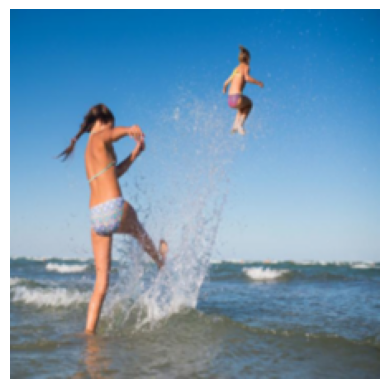

In [8]:
MODELS_DIR = "models/"
RESULTS_PATH = "results/"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_PATH = "./images/test.png"
IMAGE_NAME = IMAGE_PATH.split("/")[-1].split(".")[0] + "/"

img = get_image(IMAGE_PATH, img_shape=(224, 224))  # resize to 224x224!
print("This is gonna be the image analyzed:")
plot_image(img.squeeze(0))

In [9]:
def read_log(log_path: str) -> pd.DataFrame:
    with open(log_path, "r") as f:
        lines = f.readlines()
    log_data = [json.loads(line) for line in lines]
    return pd.DataFrame(log_data)


def load_model(model_path: str) -> nn.Module:
    model = torch.load(model_path, map_location=DEVICE)
    return model


def top_norm_tokens(
    test_model: nn.Module, block: int = None, discard_tokens: int = 0
) -> np.ndarray:
    """Get sorted tokens with the highest norm values from the last block"""
    if block is None:
        block = len(test_model.blocks) - 1

    output = test_model.block_output["block" + str(block)]
    # output = output.squeeze(0)
    if discard_tokens > 0:
        output = output[
            :, 1:-discard_tokens
        ]  # discard the CLS token and 4 register tokens
    else:
        output = output[:, 1:]
    output_norms = output.norm(dim=-1)
    top_tokens = torch.argsort(output_norms, descending=True, dim=1)

    return top_tokens.cpu().numpy()


def top_attn_tokens(
    test_model: nn.Module, block: int = None, discard_tokens: int = 0
) -> np.ndarray:
    """Get sorted tokens with the highest attention values from the last block"""
    if block is None:
        block = len(test_model.blocks) - 1
    attn_map_mean = test_model.blocks[block].attn.attn_map.mean(dim=1)
    if discard_tokens > 0:
        top_tokens = torch.argsort(
            attn_map_mean[:, 0, 1:-discard_tokens], descending=True
        )
    else:
        top_tokens = torch.argsort(attn_map_mean[:, 0, 1:], descending=True)
    return top_tokens.cpu().numpy()


def find_high_norm_attn_intersection(
    test_model: nn.Module, block: int = None, top_n: int = 10
) -> np.ndarray:
    """Find the intersection of top tokens with the highest norm and attention values"""
    intersection = []
    top_norm = top_norm_tokens(test_model, block)[:, :top_n]
    top_attn = top_attn_tokens(test_model, block)[:, :top_n]

    for i in range(top_norm.shape[0]):
        intersection.append(np.intersect1d(top_attn[i], top_norm[i]))
    return intersection

In [10]:
if os.path.exists(MODELS_DIR):
    model_folders = [
        folder
        for folder in os.listdir(MODELS_DIR)
        if os.path.isdir(os.path.join(MODELS_DIR, folder))
    ]
    print(f"Found the following folders in {MODELS_DIR}: {model_folders}")
else:
    print(f"The directory {MODELS_DIR} does not exist.")

Found the following folders in models/: ['ep_10_lay_10_reg_0_l2_001', 'ep_10_lay_10_reg_0_l2_01', 'ep_10_lay_10_reg_4_l2_0', 'ep_10_lay_10_reg_4_l2_001', 'ep_10_lay_10_reg_4_l2_01', 'ep_10_lay_11_reg_0_l2_001', 'ep_10_lay_11_reg_0_l2_01', 'ep_10_lay_11_reg_4_l2_0', 'ep_10_lay_11_reg_4_l2_001', 'ep_10_lay_11_reg_4_l2_01', 'ep_10_lay_8_reg_0_l2_001', 'ep_10_lay_8_reg_0_l2_01', 'ep_10_lay_8_reg_4_l2_0', 'ep_10_lay_8_reg_4_l2_001', 'ep_10_lay_8_reg_4_l2_01', 'ep_10_lay_9_reg_0_l2_001', 'ep_10_lay_9_reg_0_l2_01', 'ep_10_lay_9_reg_4_l2_0', 'ep_10_lay_9_reg_4_l2_001', 'ep_10_lay_9_reg_4_l2_01', 'ep_20_lay_10_reg_4_l2_01', 'ep_20_lay_9_reg_4_l2_01']


## Repeating the experiments

In [ ]:
for folder in sorted(model_folders):
    temp_results_folder = os.path.join(RESULTS_PATH, IMAGE_NAME, folder)
    print(f"Creating results folder {temp_results_folder}")
    # make directory if it doesn't exist
    if not os.path.exists(temp_results_folder):
        os.makedirs(temp_results_folder)

    print(f"Analyzing model in folder {folder}")
    results_dir = os.path.join(MODELS_DIR, folder)
    # print(results_dir)
    model_path = os.path.join(results_dir, "checkpoint.pth")
    model_dict = load_model(model_path)

    # instantiate a model with registers
    ft_model = deit_small_patch16_LS_reg(pretrained=False, num_classes=1000)
    # load a pretrained state dict containing register_tokens
    ft_model.load_pretrained_state_dict(model_dict["model"])
    ft_model = ft_model.to(DEVICE).eval()
    ft_model(img)  # do it to have the attn_map!

    try:
        number_of_registers = ft_model.register_tokens.shape[0]
        print("Registers shape: ", ft_model.register_tokens.shape, "\n")
    except:
        number_of_registers = 0
        print("No registers found\n")

    show_attn_progression(
        ft_model,
        token="cls",
        grid_size=(14, 14),
        discard_tokens=number_of_registers,
        save_path=temp_results_folder + "/cls.png",
    )

    if number_of_registers > 0:
        show_attn_progression(
            ft_model,
            token="reg",
            grid_size=(14, 14),
            discard_tokens=number_of_registers,
            save_path=temp_results_folder + "/reg0.png",
        )

Creating results folder results/test/ep_10_lay_10_reg_0_l2_001
Analyzing model in folder ep_10_lay_10_reg_0_l2_001


C:\Users\agata\AppData\Local\Temp\ipykernel_18860\3725013168.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=DEVICE)


>>>>>>>>>>>>>>>>>>>> NUMBER OF REGISTERS: 0
No registers found

Creating results folder results/test/ep_10_lay_10_reg_0_l2_01
Analyzing model in folder ep_10_lay_10_reg_0_l2_01
>>>>>>>>>>>>>>>>>>>> NUMBER OF REGISTERS: 0
No registers found

Creating results folder results/test/ep_10_lay_10_reg_4_l2_0
Analyzing model in folder ep_10_lay_10_reg_4_l2_0
>>>>>>>>>>>>>>>>>>>> NUMBER OF REGISTERS: 0
Loading 4 register tokens.
Registers shape:  torch.Size([4, 384]) 

Creating results folder results/test/ep_10_lay_10_reg_4_l2_001
Analyzing model in folder ep_10_lay_10_reg_4_l2_001
>>>>>>>>>>>>>>>>>>>> NUMBER OF REGISTERS: 0
Loading 4 register tokens.
Registers shape:  torch.Size([4, 384]) 

Creating results folder results/test/ep_10_lay_10_reg_4_l2_01
Analyzing model in folder ep_10_lay_10_reg_4_l2_01
>>>>>>>>>>>>>>>>>>>> NUMBER OF REGISTERS: 0
Loading 4 register tokens.
Registers shape:  torch.Size([4, 384]) 

Creating results folder results/test/ep_10_lay_11_reg_0_l2_001
Analyzing model in fo